## Self Supervised Learning by Convolutional Auto-Encoder with Random Images

Train Convolutional Auto-Encoder with Random Images

In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch import rand, randn

data_dir = 'data'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)


In [2]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
        #     nn.Linear(3 * 3 * 32, 128),
        #     nn.ReLU(True),
        #     nn.Linear(128, encoded_space_dim)
            nn.Linear(7 * 7 * 16, encoded_space_dim) 
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
#        print(x.shape)
        x = self.flatten(x)
#        print(x.shape)
        x = self.encoder_lin(x)
#        print(x.shape)
        return x

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            # nn.Linear(encoded_space_dim, 128),
            # nn.ReLU(True),
            # nn.Linear(128, 3 * 3 * 32),
            nn.Linear(encoded_space_dim, 7 * 7 * 16),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(16, 7, 7))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(16, 16, 3, stride=2, padding=1, output_padding=1),
            nn.Conv2d(16, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 1, 3, stride=1, padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
#        print(x.shape)
        x = self.unflatten(x)
#        print(x.shape)
        x = self.decoder_conv(x)
#        print(x.shape)
        x = torch.sigmoid(x)
        return x

In [3]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 100

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=100, out_features=784, bias=True)
    (1): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(16, 7, 7))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [4]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        image_batch = rand((255, 1, 28, 28))
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
#        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [5]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = rand((255, 1, 28, 28))
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [6]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      # img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      img = rand((1, 1, 28, 28)).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

EPOCH 1/200 	 train loss 0.08119893819093704 	 val loss 0.07683645188808441
EPOCH 2/200 	 train loss 0.07497529685497284 	 val loss 0.07390515506267548
EPOCH 3/200 	 train loss 0.07342911511659622 	 val loss 0.07325303554534912
EPOCH 4/200 	 train loss 0.07323148101568222 	 val loss 0.07316900044679642
EPOCH 5/200 	 train loss 0.07315051555633545 	 val loss 0.07315051555633545
EPOCH 6/200 	 train loss 0.07312490791082382 	 val loss 0.0731380358338356
EPOCH 7/200 	 train loss 0.07311771810054779 	 val loss 0.0731160119175911
EPOCH 8/200 	 train loss 0.07306220382452011 	 val loss 0.07310536503791809
EPOCH 9/200 	 train loss 0.07308952510356903 	 val loss 0.07313472032546997
EPOCH 10/200 	 train loss 0.07308568060398102 	 val loss 0.07305680960416794


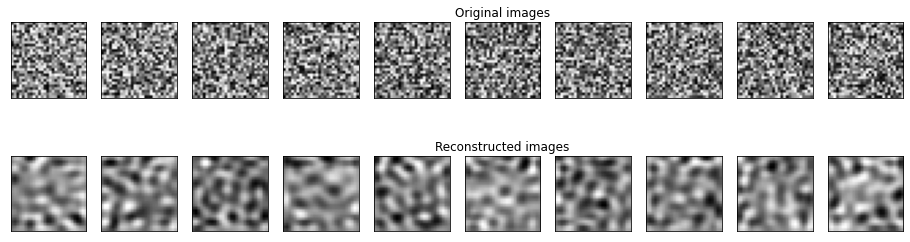

EPOCH 11/200 	 train loss 0.07306123524904251 	 val loss 0.07304966449737549
EPOCH 12/200 	 train loss 0.07306403666734695 	 val loss 0.07311024516820908
EPOCH 13/200 	 train loss 0.07305514812469482 	 val loss 0.07307323068380356
EPOCH 14/200 	 train loss 0.07303477078676224 	 val loss 0.07305122911930084
EPOCH 15/200 	 train loss 0.07304971665143967 	 val loss 0.0731174573302269
EPOCH 16/200 	 train loss 0.07303299009799957 	 val loss 0.07304055243730545
EPOCH 17/200 	 train loss 0.07307081669569016 	 val loss 0.0731155276298523
EPOCH 18/200 	 train loss 0.07303285598754883 	 val loss 0.07315008342266083
EPOCH 19/200 	 train loss 0.07301851361989975 	 val loss 0.07304229587316513
EPOCH 20/200 	 train loss 0.07301604747772217 	 val loss 0.07307026535272598


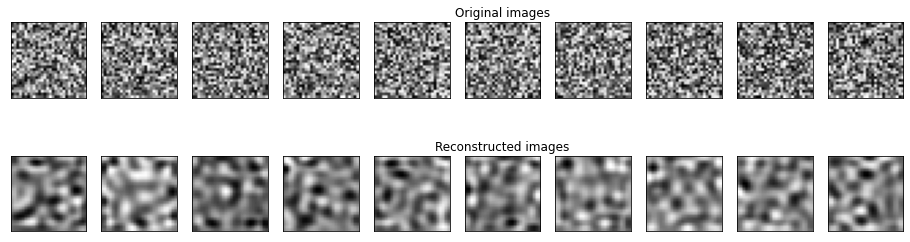

EPOCH 21/200 	 train loss 0.07302677631378174 	 val loss 0.07307188957929611
EPOCH 22/200 	 train loss 0.0730157196521759 	 val loss 0.07307997345924377
EPOCH 23/200 	 train loss 0.07300472259521484 	 val loss 0.0730910524725914
EPOCH 24/200 	 train loss 0.07301437854766846 	 val loss 0.0731177031993866
EPOCH 25/200 	 train loss 0.07302220165729523 	 val loss 0.07305131107568741
EPOCH 26/200 	 train loss 0.073012575507164 	 val loss 0.07332804799079895
EPOCH 27/200 	 train loss 0.07302438467741013 	 val loss 0.0732770636677742
EPOCH 28/200 	 train loss 0.07302606105804443 	 val loss 0.07302296161651611
EPOCH 29/200 	 train loss 0.07300814241170883 	 val loss 0.07302267849445343
EPOCH 30/200 	 train loss 0.07302749156951904 	 val loss 0.07301986962556839


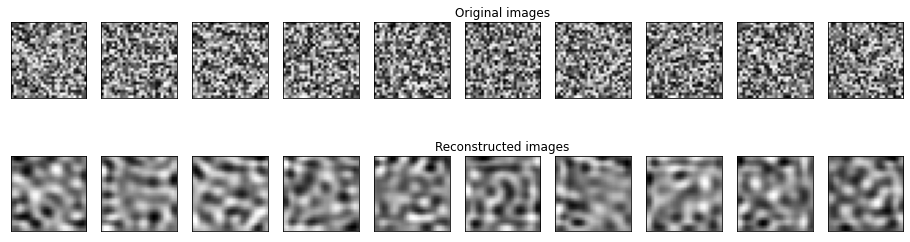

EPOCH 31/200 	 train loss 0.07301889359951019 	 val loss 0.07305985689163208
EPOCH 32/200 	 train loss 0.07300267368555069 	 val loss 0.07298150658607483
EPOCH 33/200 	 train loss 0.0730057805776596 	 val loss 0.07310809195041656
EPOCH 34/200 	 train loss 0.07300366461277008 	 val loss 0.07304777950048447
EPOCH 35/200 	 train loss 0.07301561534404755 	 val loss 0.07319261133670807
EPOCH 36/200 	 train loss 0.07300206273794174 	 val loss 0.07308329641819
EPOCH 37/200 	 train loss 0.07298770546913147 	 val loss 0.07306577265262604
EPOCH 38/200 	 train loss 0.0730113834142685 	 val loss 0.0730111226439476
EPOCH 39/200 	 train loss 0.07299385964870453 	 val loss 0.07308748364448547
EPOCH 40/200 	 train loss 0.07298268377780914 	 val loss 0.07301568239927292


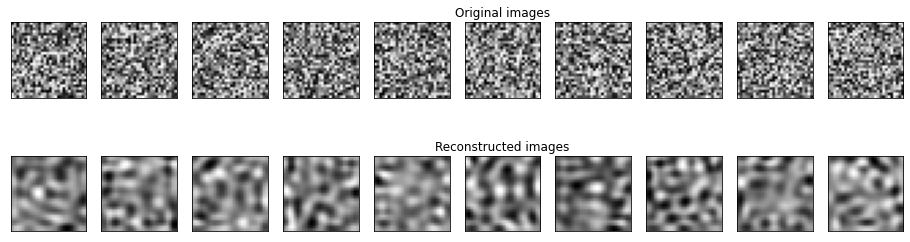

EPOCH 41/200 	 train loss 0.0730103850364685 	 val loss 0.073097363114357
EPOCH 42/200 	 train loss 0.07302407920360565 	 val loss 0.07315103709697723
EPOCH 43/200 	 train loss 0.07302276045084 	 val loss 0.07304473221302032
EPOCH 44/200 	 train loss 0.07299669086933136 	 val loss 0.07322238385677338
EPOCH 45/200 	 train loss 0.07298287004232407 	 val loss 0.07358106970787048
EPOCH 46/200 	 train loss 0.07298246771097183 	 val loss 0.07304498553276062
EPOCH 47/200 	 train loss 0.07301842421293259 	 val loss 0.07300012558698654
EPOCH 48/200 	 train loss 0.07297755777835846 	 val loss 0.07314684987068176
EPOCH 49/200 	 train loss 0.07299362868070602 	 val loss 0.0729992464184761
EPOCH 50/200 	 train loss 0.07299484312534332 	 val loss 0.07299760729074478


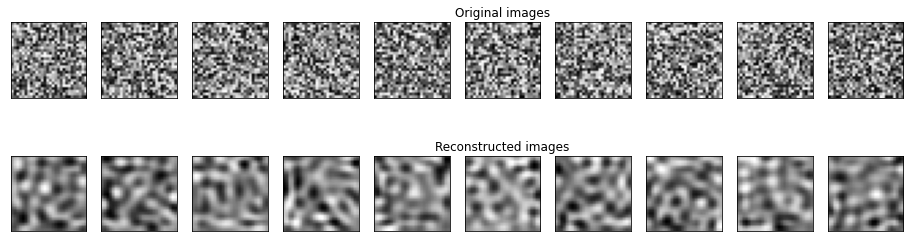

EPOCH 51/200 	 train loss 0.07299710065126419 	 val loss 0.07302290201187134
EPOCH 52/200 	 train loss 0.07297322899103165 	 val loss 0.07304750382900238
EPOCH 53/200 	 train loss 0.07298286259174347 	 val loss 0.07327365130186081
EPOCH 54/200 	 train loss 0.0730036199092865 	 val loss 0.07313035428524017
EPOCH 55/200 	 train loss 0.07298882305622101 	 val loss 0.07320163398981094
EPOCH 56/200 	 train loss 0.07301868498325348 	 val loss 0.07311703264713287
EPOCH 57/200 	 train loss 0.07298470288515091 	 val loss 0.0731707215309143
EPOCH 58/200 	 train loss 0.07301776111125946 	 val loss 0.07307954132556915
EPOCH 59/200 	 train loss 0.07299719750881195 	 val loss 0.07319733500480652
EPOCH 60/200 	 train loss 0.07297004759311676 	 val loss 0.07305961102247238


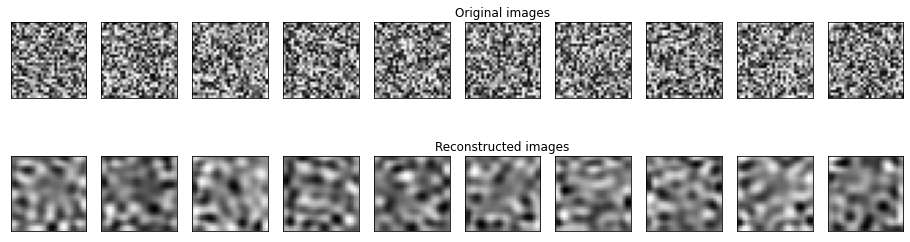

EPOCH 61/200 	 train loss 0.07299888134002686 	 val loss 0.07321237772703171
EPOCH 62/200 	 train loss 0.07299879193305969 	 val loss 0.07323611527681351
EPOCH 63/200 	 train loss 0.07298265397548676 	 val loss 0.07303837686777115
EPOCH 64/200 	 train loss 0.07297588884830475 	 val loss 0.07309892773628235
EPOCH 65/200 	 train loss 0.07299033552408218 	 val loss 0.07295933365821838
EPOCH 66/200 	 train loss 0.07299777120351791 	 val loss 0.07298314571380615
EPOCH 67/200 	 train loss 0.07297764718532562 	 val loss 0.07308157533407211
EPOCH 68/200 	 train loss 0.07298752665519714 	 val loss 0.07326655834913254
EPOCH 69/200 	 train loss 0.0729866549372673 	 val loss 0.07304894179105759
EPOCH 70/200 	 train loss 0.07298767566680908 	 val loss 0.07349643111228943


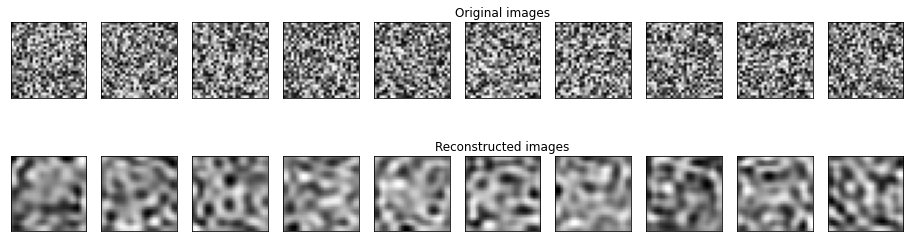

EPOCH 71/200 	 train loss 0.07296408712863922 	 val loss 0.07314278185367584
EPOCH 72/200 	 train loss 0.07297243177890778 	 val loss 0.07300516217947006
EPOCH 73/200 	 train loss 0.07297928631305695 	 val loss 0.07352359592914581
EPOCH 74/200 	 train loss 0.07298979163169861 	 val loss 0.07300108671188354
EPOCH 75/200 	 train loss 0.07298740744590759 	 val loss 0.07321895658969879
EPOCH 76/200 	 train loss 0.07299447804689407 	 val loss 0.07315816730260849
EPOCH 77/200 	 train loss 0.07298111170530319 	 val loss 0.07395581901073456
EPOCH 78/200 	 train loss 0.07297328114509583 	 val loss 0.07331231236457825
EPOCH 79/200 	 train loss 0.07299218326807022 	 val loss 0.07335009425878525
EPOCH 80/200 	 train loss 0.07298024743795395 	 val loss 0.07307186722755432


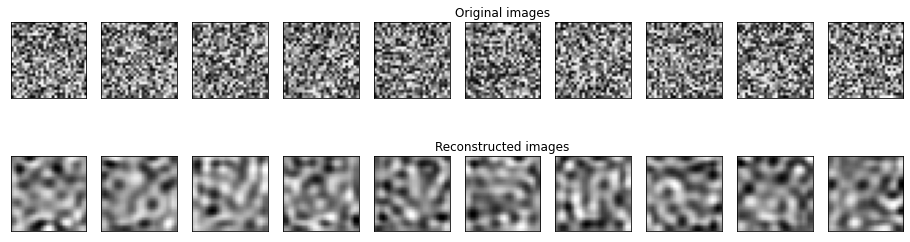

EPOCH 81/200 	 train loss 0.07300527393817902 	 val loss 0.07340062409639359
EPOCH 82/200 	 train loss 0.07298685610294342 	 val loss 0.07307711988687515
EPOCH 83/200 	 train loss 0.07297465950250626 	 val loss 0.07373138517141342
EPOCH 84/200 	 train loss 0.07299487292766571 	 val loss 0.07319516688585281
EPOCH 85/200 	 train loss 0.07299669086933136 	 val loss 0.07322406023740768
EPOCH 86/200 	 train loss 0.07297483086585999 	 val loss 0.07331790775060654
EPOCH 87/200 	 train loss 0.0729781910777092 	 val loss 0.07332435250282288
EPOCH 88/200 	 train loss 0.07299049198627472 	 val loss 0.07327435165643692
EPOCH 89/200 	 train loss 0.07298006117343903 	 val loss 0.07319631427526474
EPOCH 90/200 	 train loss 0.07296574115753174 	 val loss 0.07305601984262466


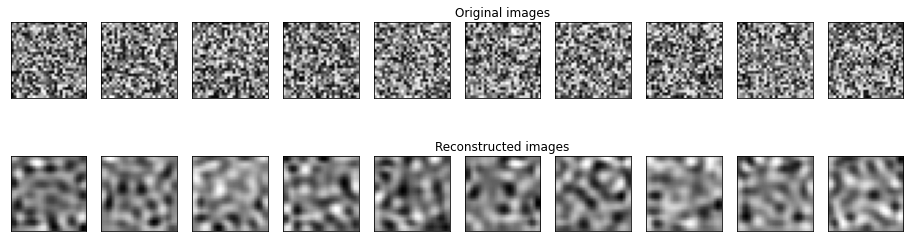

EPOCH 91/200 	 train loss 0.07299292087554932 	 val loss 0.07303879410028458
EPOCH 92/200 	 train loss 0.07295478880405426 	 val loss 0.07302802056074142
EPOCH 93/200 	 train loss 0.07297302782535553 	 val loss 0.07335301488637924
EPOCH 94/200 	 train loss 0.07299498468637466 	 val loss 0.07322405278682709
EPOCH 95/200 	 train loss 0.07301858067512512 	 val loss 0.07310274988412857
EPOCH 96/200 	 train loss 0.07300177961587906 	 val loss 0.07300227135419846
EPOCH 97/200 	 train loss 0.07297951728105545 	 val loss 0.07316797226667404
EPOCH 98/200 	 train loss 0.07298576831817627 	 val loss 0.07358507812023163
EPOCH 99/200 	 train loss 0.07299312949180603 	 val loss 0.07304350286722183
EPOCH 100/200 	 train loss 0.07298018038272858 	 val loss 0.07298753410577774


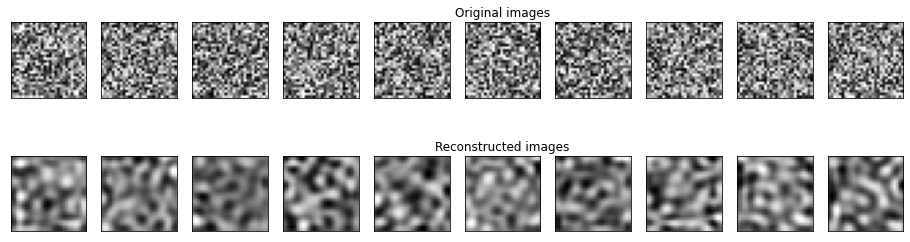

EPOCH 101/200 	 train loss 0.07298073172569275 	 val loss 0.07313146442174911
EPOCH 102/200 	 train loss 0.07299680262804031 	 val loss 0.07328883558511734
EPOCH 103/200 	 train loss 0.07297302037477493 	 val loss 0.07324079424142838
EPOCH 104/200 	 train loss 0.07298365235328674 	 val loss 0.07302084565162659
EPOCH 105/200 	 train loss 0.0729813426733017 	 val loss 0.07317019999027252
EPOCH 106/200 	 train loss 0.07298775017261505 	 val loss 0.07382682710886002
EPOCH 107/200 	 train loss 0.07297803461551666 	 val loss 0.07314226031303406
EPOCH 108/200 	 train loss 0.07297982275485992 	 val loss 0.07322169840335846
EPOCH 109/200 	 train loss 0.07297135889530182 	 val loss 0.0731547400355339
EPOCH 110/200 	 train loss 0.0729813501238823 	 val loss 0.07309523969888687


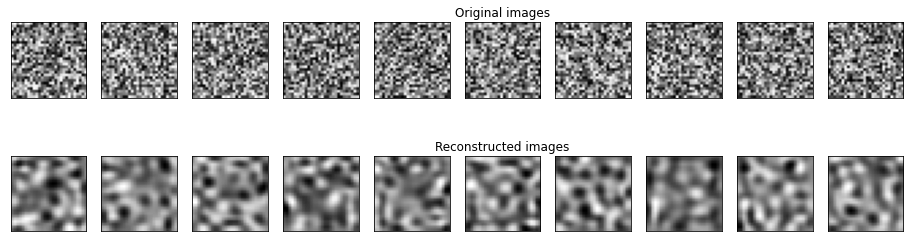

EPOCH 111/200 	 train loss 0.07297513633966446 	 val loss 0.07309126853942871
EPOCH 112/200 	 train loss 0.07296404242515564 	 val loss 0.07309229671955109
EPOCH 113/200 	 train loss 0.0729781836271286 	 val loss 0.0730704590678215
EPOCH 114/200 	 train loss 0.07297872751951218 	 val loss 0.07361331582069397
EPOCH 115/200 	 train loss 0.07298465818166733 	 val loss 0.07298747450113297
EPOCH 116/200 	 train loss 0.07296419143676758 	 val loss 0.07297588139772415
EPOCH 117/200 	 train loss 0.07297207415103912 	 val loss 0.07345000654459
EPOCH 118/200 	 train loss 0.0729888305068016 	 val loss 0.07302150130271912
EPOCH 119/200 	 train loss 0.07298414409160614 	 val loss 0.07311920821666718
EPOCH 120/200 	 train loss 0.07296682894229889 	 val loss 0.07306729257106781


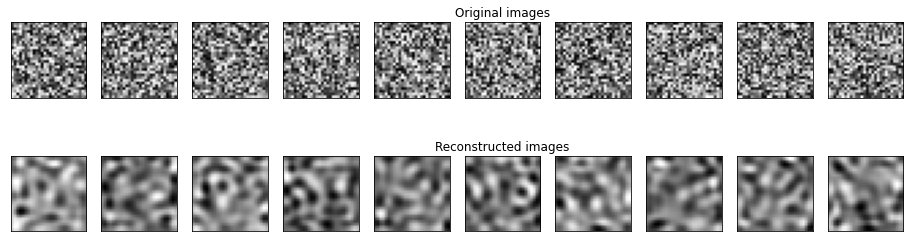

EPOCH 121/200 	 train loss 0.07295313477516174 	 val loss 0.07312196493148804
EPOCH 122/200 	 train loss 0.07298622280359268 	 val loss 0.0730435848236084
EPOCH 123/200 	 train loss 0.07298150658607483 	 val loss 0.0742047131061554
EPOCH 124/200 	 train loss 0.07298128306865692 	 val loss 0.0735502615571022
EPOCH 125/200 	 train loss 0.072982557117939 	 val loss 0.0733606368303299
EPOCH 126/200 	 train loss 0.07297257333993912 	 val loss 0.07378879934549332
EPOCH 127/200 	 train loss 0.07296637445688248 	 val loss 0.07342225313186646
EPOCH 128/200 	 train loss 0.07295563071966171 	 val loss 0.0734681636095047
EPOCH 129/200 	 train loss 0.07297366857528687 	 val loss 0.07313399761915207
EPOCH 130/200 	 train loss 0.0729731097817421 	 val loss 0.07322443276643753


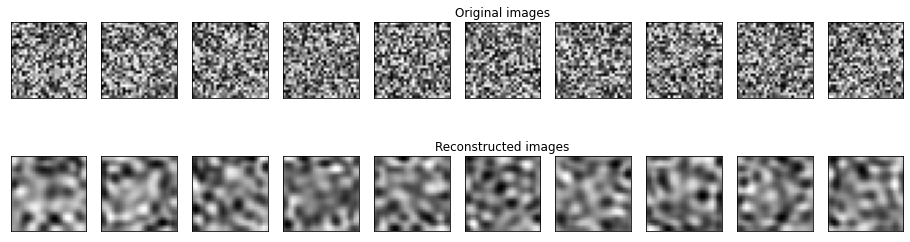

EPOCH 131/200 	 train loss 0.07295531779527664 	 val loss 0.07346856594085693
EPOCH 132/200 	 train loss 0.07296588271856308 	 val loss 0.07419490814208984
EPOCH 133/200 	 train loss 0.07298381626605988 	 val loss 0.0731268972158432
EPOCH 134/200 	 train loss 0.0729714184999466 	 val loss 0.07321463525295258
EPOCH 135/200 	 train loss 0.07298213988542557 	 val loss 0.07305453717708588
EPOCH 136/200 	 train loss 0.07298049330711365 	 val loss 0.07311496138572693
EPOCH 137/200 	 train loss 0.07297971844673157 	 val loss 0.07314589619636536
EPOCH 138/200 	 train loss 0.07296808063983917 	 val loss 0.07307376712560654
EPOCH 139/200 	 train loss 0.0729791596531868 	 val loss 0.07302673906087875
EPOCH 140/200 	 train loss 0.07298144698143005 	 val loss 0.07327614724636078


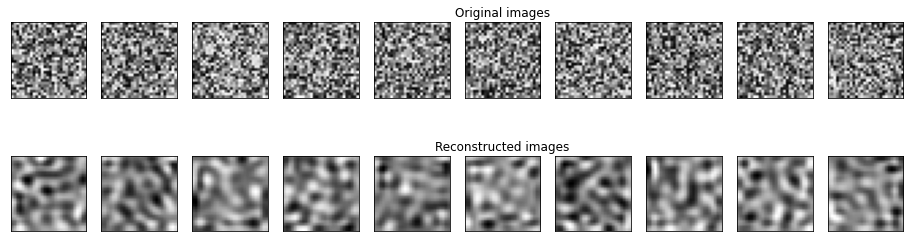

EPOCH 141/200 	 train loss 0.07297614961862564 	 val loss 0.07316794246435165
EPOCH 142/200 	 train loss 0.072995126247406 	 val loss 0.07313980162143707
EPOCH 143/200 	 train loss 0.07297758758068085 	 val loss 0.07317210733890533
EPOCH 144/200 	 train loss 0.07295896857976913 	 val loss 0.07335337996482849
EPOCH 145/200 	 train loss 0.07297689467668533 	 val loss 0.07307872921228409
EPOCH 146/200 	 train loss 0.0729672759771347 	 val loss 0.07323309034109116
EPOCH 147/200 	 train loss 0.07297010719776154 	 val loss 0.07295962423086166
EPOCH 148/200 	 train loss 0.07297014445066452 	 val loss 0.0733642652630806
EPOCH 149/200 	 train loss 0.07297635823488235 	 val loss 0.07333352416753769
EPOCH 150/200 	 train loss 0.07296135276556015 	 val loss 0.0733301043510437


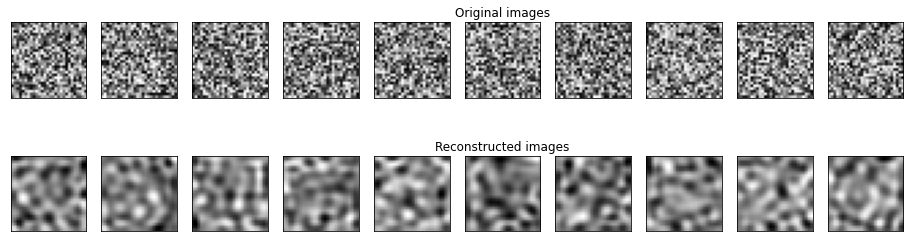

EPOCH 151/200 	 train loss 0.07295543700456619 	 val loss 0.07294497638940811
EPOCH 152/200 	 train loss 0.072969950735569 	 val loss 0.07297089695930481
EPOCH 153/200 	 train loss 0.07299567013978958 	 val loss 0.07339193671941757
EPOCH 154/200 	 train loss 0.0729791447520256 	 val loss 0.07347937673330307
EPOCH 155/200 	 train loss 0.07297030091285706 	 val loss 0.07326414436101913
EPOCH 156/200 	 train loss 0.07296023517847061 	 val loss 0.07381857186555862
EPOCH 157/200 	 train loss 0.07297249883413315 	 val loss 0.07326866686344147
EPOCH 158/200 	 train loss 0.07296154648065567 	 val loss 0.07295619696378708
EPOCH 159/200 	 train loss 0.07294399291276932 	 val loss 0.07337816804647446
EPOCH 160/200 	 train loss 0.0729699358344078 	 val loss 0.07332970947027206


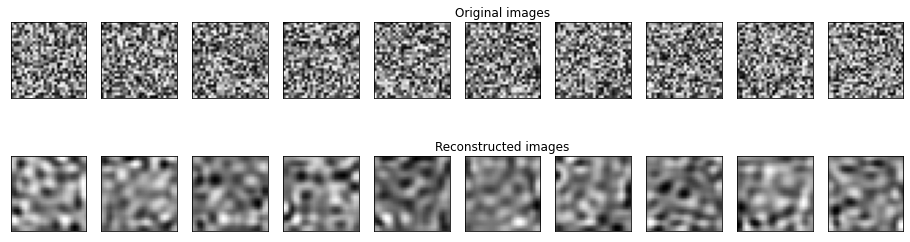

EPOCH 161/200 	 train loss 0.0729878842830658 	 val loss 0.07331816107034683
EPOCH 162/200 	 train loss 0.07294720411300659 	 val loss 0.07304156571626663
EPOCH 163/200 	 train loss 0.07296416908502579 	 val loss 0.07356570661067963
EPOCH 164/200 	 train loss 0.0729660764336586 	 val loss 0.07314999401569366
EPOCH 165/200 	 train loss 0.0729638859629631 	 val loss 0.07309792935848236
EPOCH 166/200 	 train loss 0.07298506796360016 	 val loss 0.0731675773859024
EPOCH 167/200 	 train loss 0.07296903431415558 	 val loss 0.0731034204363823
EPOCH 168/200 	 train loss 0.07296859472990036 	 val loss 0.07335163652896881
EPOCH 169/200 	 train loss 0.07298863679170609 	 val loss 0.07311750203371048
EPOCH 170/200 	 train loss 0.07294595241546631 	 val loss 0.07304376363754272


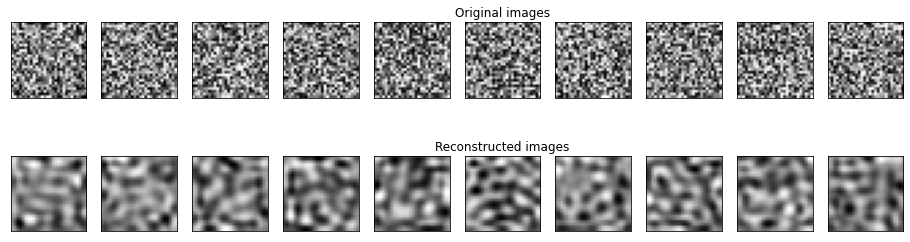

EPOCH 171/200 	 train loss 0.07296839356422424 	 val loss 0.07321300357580185
EPOCH 172/200 	 train loss 0.07295208424329758 	 val loss 0.07322278618812561
EPOCH 173/200 	 train loss 0.07296483218669891 	 val loss 0.07348589599132538
EPOCH 174/200 	 train loss 0.07296881079673767 	 val loss 0.07303173094987869
EPOCH 175/200 	 train loss 0.07295509427785873 	 val loss 0.07331225275993347
EPOCH 176/200 	 train loss 0.0729750245809555 	 val loss 0.07318364828824997
EPOCH 177/200 	 train loss 0.07296449691057205 	 val loss 0.07302595674991608
EPOCH 178/200 	 train loss 0.07294216752052307 	 val loss 0.0732603520154953
EPOCH 179/200 	 train loss 0.07296233624219894 	 val loss 0.07319505512714386
EPOCH 180/200 	 train loss 0.07297415286302567 	 val loss 0.0730733796954155


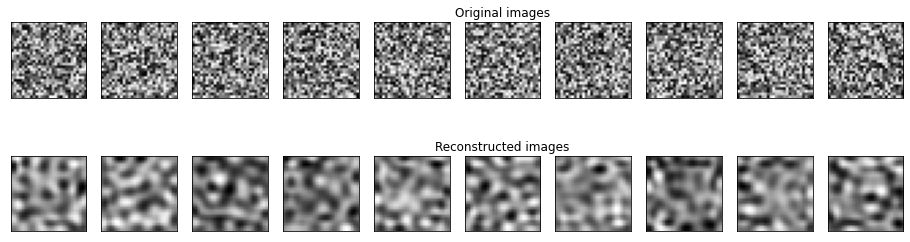

EPOCH 181/200 	 train loss 0.07297564297914505 	 val loss 0.07366472482681274
EPOCH 182/200 	 train loss 0.07296593487262726 	 val loss 0.07325437664985657
EPOCH 183/200 	 train loss 0.07296004891395569 	 val loss 0.07297247648239136
EPOCH 184/200 	 train loss 0.07296944409608841 	 val loss 0.0730779841542244
EPOCH 185/200 	 train loss 0.07295586913824081 	 val loss 0.07354067265987396
EPOCH 186/200 	 train loss 0.07294882088899612 	 val loss 0.07304438203573227
EPOCH 187/200 	 train loss 0.07297333329916 	 val loss 0.07302684336900711
EPOCH 188/200 	 train loss 0.07297486811876297 	 val loss 0.07345981895923615
EPOCH 189/200 	 train loss 0.0729735791683197 	 val loss 0.07342125475406647
EPOCH 190/200 	 train loss 0.0729481652379036 	 val loss 0.07367968559265137


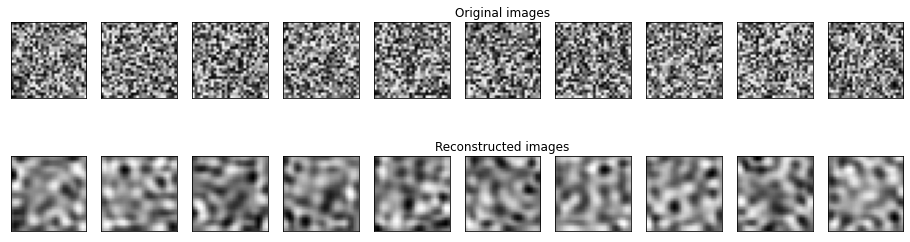

EPOCH 191/200 	 train loss 0.07295739650726318 	 val loss 0.07304999977350235
EPOCH 192/200 	 train loss 0.07298124581575394 	 val loss 0.0730244442820549
EPOCH 193/200 	 train loss 0.07296114414930344 	 val loss 0.07301907241344452
EPOCH 194/200 	 train loss 0.07296206057071686 	 val loss 0.07316137850284576
EPOCH 195/200 	 train loss 0.07297664880752563 	 val loss 0.07314056903123856
EPOCH 196/200 	 train loss 0.07298601418733597 	 val loss 0.07321251183748245
EPOCH 197/200 	 train loss 0.07295551896095276 	 val loss 0.07319390028715134
EPOCH 198/200 	 train loss 0.07296930253505707 	 val loss 0.07318123430013657
EPOCH 199/200 	 train loss 0.07299032807350159 	 val loss 0.07362447679042816
EPOCH 200/200 	 train loss 0.07295768707990646 	 val loss 0.07297015935182571


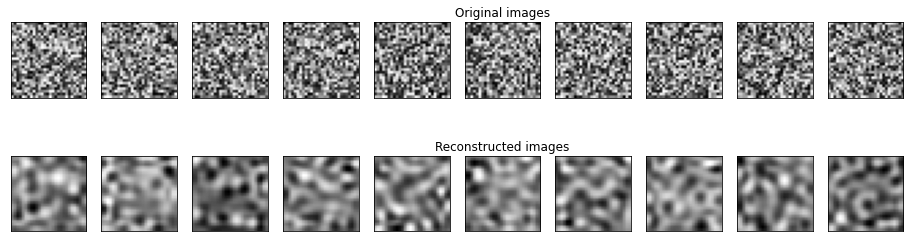

In [7]:
num_epochs = 200
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   if (((epoch+1) % 10) == 0):
      plot_ae_outputs(encoder,decoder,n=10)

In [8]:
def plot_ae_outputs_mnist(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

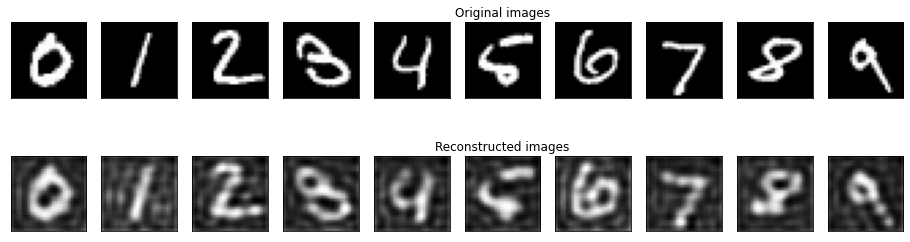

In [9]:
plot_ae_outputs_mnist(encoder, decoder, 10)

In [12]:
### Feature Extraction by Encoder
encoder.eval()
with torch.no_grad(): # No need to track the gradients
    # Define the lists to store the outputs for each batch
    conc_out = []
    conc_label = []
    for image_batch, label_batch in train_loader:
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Append the network output and the original image to the lists
        conc_out.append(encoded_data.cpu())
        conc_label.append(label_batch)
    # Create a single tensor with all the values in the lists
    conc_out = torch.cat(conc_out)
    conc_label = torch.cat(conc_label)



conc_out
 torch.Size([48000, 100])
conc_label
 torch.Size([48000])


In [14]:
train_features = conc_out.detach().numpy().copy()
train_labels = conc_label.detach().numpy().copy()
print('train_features\n', train_features.shape)
print('train_labels\n', train_labels.shape)


train_features
 (48000, 100)
train_labels
 (48000,)
